# 11. Sequence processing with convnets

In [54]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from IPython.display import HTML

# Common imports
import numpy as np
import os
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import matplotlib.image as mpimg
def plot_external(img):
    img_name = os.path.join(".", "images",img)
    plots = mpimg.imread(img_name)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def plot_external2(imgpath):    
    plots = mpimg.imread(imgpath)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()  

# batch function
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        
from tensorflow.keras.backend import clear_session

def makedir(path):
    if not os.path.isdir(path):
        os.makedirs(path)
        print("directory created!!")
    else:
        print("directory exist!!")
        

class LossAndError(tf.keras.callbacks.Callback):
    def __init__(self, epochs, class_mode):
        self.epochs = epochs
        
        # class_mode: binary_accuracy, sparse_categorical_crossentropy, 
        # mean_absolute_error, mean_squared_error, categorical_crossentropy        
        self.class_mode = class_mode
        self.val_class_mode = "val_" + self.class_mode
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch                
              
    def on_train_batch_end(self, batch, logs=None):        
        print('\repoch: {}, loss {:.5f}, {} {:.5f}'.format(self.epoch+1, 
                                                            logs['loss'], 
                                                            self.class_mode, 
                                                            logs[self.class_mode]), end=" ")
              
    def on_epoch_end(self, epoch, logs=None):        
        if epoch == 0:
            print("\nhistory key: {}".format(list(logs.keys())))
            
        self.n_batch_steps = self.epochs // 5
        if (epoch+1) % self.n_batch_steps == 0 or epoch+1 == self.epochs:
            print("\rEpoch {}/{}".format(epoch+1, self.epochs), end=" ")
            print("loss: {:.5f}".format(logs["loss"]), end=" ")
            print("{}: {:.5f}".format(self.class_mode, logs[self.class_mode]), end=" ")
            print("val_loss: {:.5f}".format(logs["val_loss"]), end=" ")
            print("{}: {:.5f}".format(self.val_class_mode, logs[self.val_class_mode]))
            
def loss_and_acc_plot(history, class_mode, num_plots=2):
    history_dict = history.history
    
    loss = history_dict["loss"]
    val_loss = history_dict["val_loss"]
    
    acc = history_dict[class_mode]
    
    val_class_mode = "val_" + class_mode
    val_acc = history_dict[val_class_mode]
    
    epochs = range(1, len(loss)+1)
    
    if num_plots==2:
        plt.figure(figsize=(20, 8))
        plt.subplot(121)
        plt.plot(epochs, loss, "bo-", label="training loss")
        plt.plot(epochs, val_loss, "ro--", markerfacecolor="red", markeredgecolor="red", label="validation loss")
        plt.title("Training and validation loss", fontsize=18)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(122)
        plt.plot(epochs, acc, "bo-", label="training accuracy")
        plt.plot(epochs, val_acc, "ro--", markerfacecolor="red", markeredgecolor="red", label="validation accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training and Validation accuracy", fontsize=18)
        plt.legend()
        plt.show()
    
    if num_plots==1:
        plt.figure(figsize=(12, 8))
        plt.subplot(111)
        plt.plot(epochs, loss, "bo-", label="training loss")
        plt.plot(epochs, val_loss, "ro--", markerfacecolor="red", markeredgecolor="red", label="validation loss")
        plt.title("Training and validation loss", fontsize=18)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()    

입력의 부분 패치에서 특성을 뽑아내어 구조적인 표현을 만들고 데이터를 효율적으로 사용하는 합성곱 연산의 능력 때문에 컴퓨터 비전 문제에 잘 맞습니다. 컴퓨터 비전에서 뛰어난 컨브넷의 특징이 시퀀스 처리와도 깊게 관련되어 있습니다. 시간을 2D 이미지의 높이와 너비 같은 공간의 차원으로 다룰 수 있습니다.  

1D 컨브넷(1D Convnet)은 특정 시퀀스 처리 문제에서 RNN과 견줄 만합니다. 일반적으로 계산비용이 훨씬 쌉니다. 1D 컨브넷은 전형적으로 팽창된 커널(dilated kernel)과 함께 사용됩니다. dilated convolution은 커널에 구멍을 추가하여 입력을 건너뛰면서 합성곱하는 것과 같습니다. 최근에는 오디오 생성과 기계 번역 분야에서 큰 성공을 거두었습니다. 이런 특정 분야의 성공 이외에도 텍스트 분류나 시계열 예측 같은 간단한 문제에서 작은 1D 컨브넷이 RNN을 대신하여 빠르게 처리할 수 있다고 알려져 있습니다.

## 11.1 Understanding 1D convolution for sequence data

이미지 텐서에서 2D 패치를 추출하고 모든 패치에 동일한 변환을 적용합니다. 같은 방식으로 시퀀스에서 1D 패치(부분 시퀀스)를 추출하여 1D 합성곱을 적용합니다.

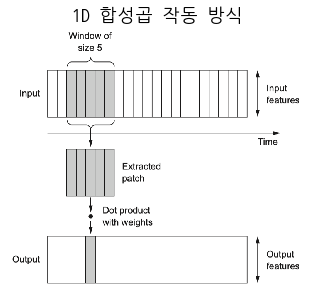

In [2]:
plt.figure(figsize=(10, 5))
plt.title("1D 합성곱 작동 방식", fontsize=18)
plot_external2("./images/ch11/1.png")
plt.show()

이런 1D 합성곱 층은 시퀀스에 있는 지역 패턴을 인식할 수 있습니다. 동일한 변환이 시퀀스에 있는 모든 패치에 적용되기 때문에 특성 위치에서 학습한 패턴을 나중에 다른 위치에서 인식할 수 있습니다. 이는 1D 컨브넷에 (시간의 이동에 대한) 이동 불변성(translation invariant)을 제공합니다. 예를 들어 크기 5인 윈도우를 사용하여 문자 시퀀스를 처리하는 1D 컨브넷은 5개 이하의 단어나 단어의 부분을 학습합니다. 이 컨브넷은 이 단어가 입력 시퀀스의 어느 문장에 있더라도 인식할 수 있습니다. 따라서 문자 수준의 1D 컨브넷은 단어 형태학(word morphology)에 관해 학습할 수 있습니다. 

<br>

## 11.2 Implementing a 1D convnet

케라스에서 1D 컨브넷은 Conv1D 층을 사용하여 구현합니다. Conv1D는 Conv2D와 인터페이스가 비슷합니다. (samples, time, features) 크기의 3D 텐서를 입력받고 비슷한 형태의 3D 텐서를 반환합니다. 합성곱 윈도우는 시간 축의 1D 윈도우입니다. 즉, 입력 텐서의 두 번째 축입니다.

간단한 두 개 층으로 된 1D 컨브넷을 만들어 익숙한 IMDB 감성 분류 문제에 적용해보겠습니다.

In [5]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
max_len = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)

print('데이터 로드...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
print(len(X_train), '훈련 시퀀스')
print(len(X_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)
print('X_train 크기:', X_train.shape)
print('X_test 크기:', X_test.shape)

데이터 로드...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
X_train 크기: (25000, 500)
X_test 크기: (25000, 500)


1D 컨브넷은 5장에서 사용한 2D 컨브넷과 비슷한 방식으로 구성합니다. Conv1D와 MaxPooling1D 층을 쌓고 전역 풀링 층이나 Flatten 층으로 마칩니다. 이 구조는 3D 입력을 2D 출력으로 바꾸므로 분류나 회귀를 위해 모델에 하나 이상의 Dense 층을 추가할 수 있습니다.

한 가지 다른 점은 1D 컨브넷에 큰 합성곱 윈도우를 사용할 수 있다는 것입니다. 2D 합성곱 층에서 3 × 3 합성곱 윈도우는 3 × 3 = 9 특성을 고려합니다. 하지만 1D 합성곱 층에서 크기 3인 합성곱 윈도우는 3개의 특성만 고려합니다. 그래서 1D 합성곱에 크기 7이나 9의 윈도우를 사용할 수 있습니다.

다음은 IMDB 데이터셋을 위한 1D 컨브넷의 예입니다:

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import losses, metrics
from tensorflow.keras.optimizers import Adam

clear_session()
model = tf.keras.Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

In [9]:
model.compile(optimizer=Adam(lr=1e-4),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [11]:
%%time
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    verbose=0,
                    callbacks=[LossAndError(epochs=10, 
                                            class_mode="binary_accuracy")])

W0807 15:29:24.352753 139673068541760 deprecation.py:323] From /opt/conda/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


epoch: 1, loss 0.69926, binary_accuracy 0.51765 
history key: ['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy']
Epoch 2/10 loss: 0.67041 binary_accuracy: 0.66140 val_loss: 0.67584 val_binary_accuracy: 0.61800
Epoch 4/10 loss: 0.60103 binary_accuracy: 0.82400 val_loss: 0.60699 val_binary_accuracy: 0.75180
Epoch 6/10 loss: 0.37353 binary_accuracy: 0.87125 val_loss: 0.40103 val_binary_accuracy: 0.84420
Epoch 8/10 loss: 0.23761 binary_accuracy: 0.91670 val_loss: 0.41040 val_binary_accuracy: 0.86520
Epoch 10/10 loss: 0.17057 binary_accuracy: 0.94200 val_loss: 0.45596 val_binary_accuracy: 0.86960


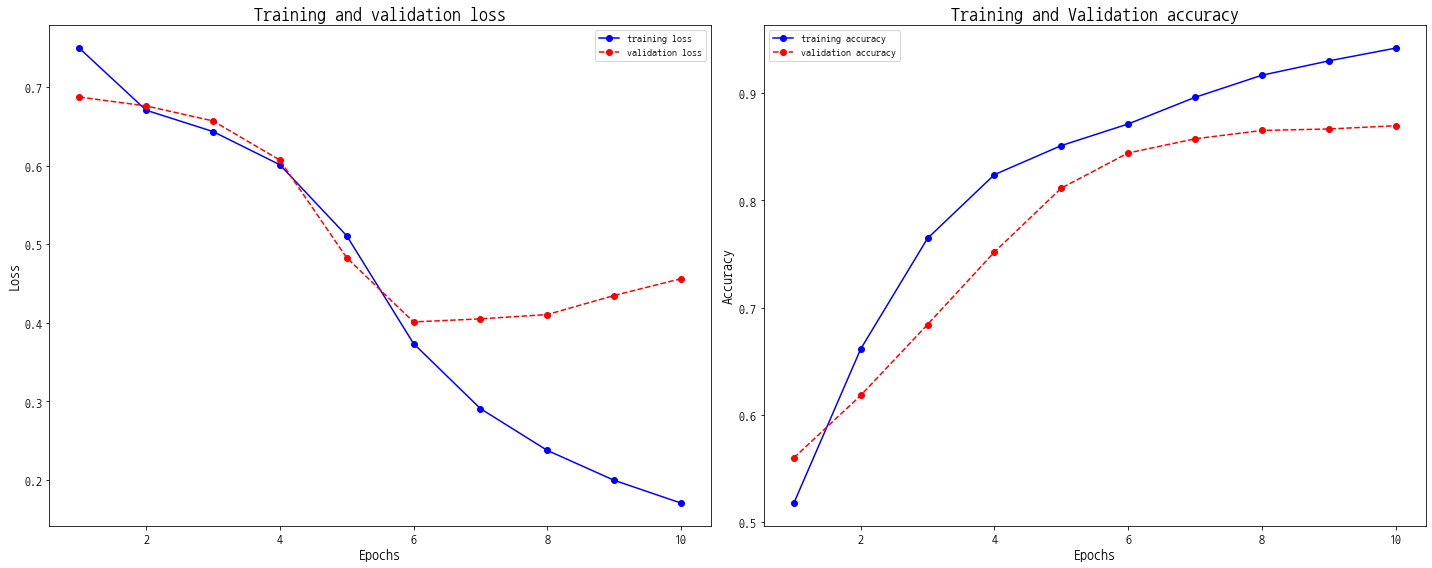

In [13]:
loss_and_acc_plot(history=history, class_mode="binary_accuracy", num_plots=2)

훈련과 검증 결과를 보여줍니다. 검증 정확도는 LSTM보다 조금 낮지만 CPU나 GPU에서 더 빠르게 실행됩니다(속도 향상은 환경에 따라 많이 다릅니다). 여기에서 적절한 에포크 수(4개)로 모델을 다시 훈련하고 테스트 세트에서 확인할 수 있습니다. 이 예는 단어 수준의 감성 분류 작업에 순환 네트워크를 대신하여 빠르고 경제적인 1D 컨브넷을 사용할 수 있음을 보여줍니다.

<br>

## 11.3 Combining CNNs and RNNs to process long sequences

1D 컨브넷이 입력 패치를 독립적으로 처리하기 때문에 RNN과 달리 (합성곱 윈도우 크기의 범위를 넘어선) 타임스텝의 순서에 민감하지 않습니다. 물론 장기간 패턴을 인식하기 위해 많은 합성곱 층과 풀링 층을 쌓을 수 있습니다. 상위 층은 원본 입력에서 긴 범위를 보게 될 것입니다. 이런 방법은 순서를 감지하기엔 부족합니다. 온도 예측 문제에 1D 컨브넷을 적용하여 이를 확인해 보겠습니다. 이 문제는 순서를 감지해야 좋은 예측을 만들어 낼 수 있습니다. 다음은 이전에 정의한 float_data, train_gen, val_gen, val_steps를 다시 사용합니다:

In [16]:
import os
import numpy as np
import pandas as pd

In [29]:
data_dir = "./datasets/jena_climate/"
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")

jena_data = pd.read_csv(fname)
jena_data_value = jena_data.values
float_data = jena_data_value[:, 1:].astype("float")
std = float_data[:200000].std(axis=0)

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(float_data[:200000])
float_data = scaler.transform(float_data)

In [30]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
# 769
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
# 930
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [39]:
from tensorflow.keras import layers
from tensorflow.keras import losses, metrics
from tensorflow.keras.optimizers import Adam

clear_session()
model = tf.keras.Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

In [40]:
model.compile(optimizer=Adam(), 
              loss=losses.mean_absolute_error,
              metrics=[metrics.mean_absolute_error])

In [41]:
epochs=20
class_mode = "mean_absolute_error"

In [42]:
%%time
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose=0,
                              callbacks=[LossAndError(epochs=epochs, class_mode=class_mode)])

epoch: 1, loss 0.32744, mean_absolute_error 0.38898 
history key: ['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error']
Epoch 4/20 loss: 0.29551 mean_absolute_error: 0.29551 val_loss: 0.45207 val_mean_absolute_error: 0.45207
Epoch 8/20 loss: 0.25847 mean_absolute_error: 0.25847 val_loss: 0.47765 val_mean_absolute_error: 0.47765
Epoch 12/20 loss: 0.24025 mean_absolute_error: 0.24025 val_loss: 0.48182 val_mean_absolute_error: 0.48182
Epoch 16/20 loss: 0.22736 mean_absolute_error: 0.22736 val_loss: 0.46475 val_mean_absolute_error: 0.46475
Epoch 20/20 loss: 0.21937 mean_absolute_error: 0.21937 val_loss: 0.47565 val_mean_absolute_error: 0.47565
CPU times: user 12min 24s, sys: 1min 56s, total: 14min 21s
Wall time: 9min


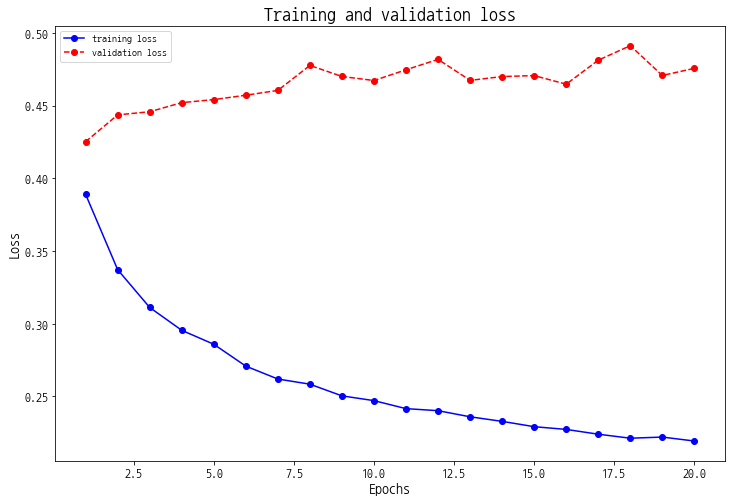

In [53]:
loss_and_acc_plot(history=history, class_mode=class_mode, num_plots=1)

검증 MAE는 0.40 대에 머물러 있습니다. 작은 컨브넷을 사용해서 상식 수준의 기준점을 넘지 못 했습니다. 이는 컨브넷이 입력 시계열에 있는 패턴을 보고 이 패턴의 시간 축의 위치(시작인지 끝 부분인지 등)를 고려하지 않기 때문입니다. 최근 데이터 포인트일수록 오래된 데이터 포인트와는 다르게 해석해야 하기 때문에 컨브넷이 의미 있는 결과를 만들지 못합니다. 이런 컨브넷의 한계는 IMDB 데이터에서는 문제가 되지 않습니다. 긍정 또는 부정적인 감성과 연관된 키워드 패턴의 중요성은 입력 시퀀스에 나타난 위치와 무관하기 때문입니다.

컨브넷의 속도와 경량함을 RNN의 순서 감지 능력과 결합하는 한가지 전략은 1D 컨브넷을 RNN 이전에 전처리 단계로 사용하는 것입니다. 수천 개의 스텝을 가진 시퀀스 같이 RNN으로 처리하기엔 현실적으로 너무 긴 시퀀스를 다룰 때 특별히 도움이 됩니다. 컨브넷이 긴 입력 시퀀스를 더 짧은 고수준 특성의 (다운 샘플된) 시퀀스로 변환합니다. 추출된 특성의 시퀀스는 RNN 파트의 입력이 됩니다.

이 기법이 연구 논문이나 실전 애플리케이션에 자주 등장하지는 않습니다. 아마도 널리 알려지지 않았기 때문일 것입니다. 이 방법은 효과적이므로 많이 사용되기를 바랍니다. 온도 예측 문제에 적용해 보죠. 이 전략은 훨씬 긴 시퀀스를 다룰 수 있으므로 더 오래전 데이터를 바라보거나(데이터 제너레이터의 lookback 매개변수를 증가시킵니다), 시계열 데이터를 더 촘촘히 바라볼 수 있습니다(제너레이터의 step 매개변수를 감소시킵니다). 여기서는 그냥 step을 절반으로 줄여서 사용하겠습니다. 온도 데이터가 30분마다 1 포인트씩 샘플링되기 때문에 결과 시계열 데이터는 두 배로 길어집니다. 앞서 정의한 제너레이터 함수를 다시 사용합니다.



In [55]:
# 이전에는 6이었습니다(시간마다 1 포인트); 이제는 3 입니다(30분마다 1 포인트)
step = 3
lookback = 1440  # 변경 안 됨
delay = 144 # 변경 안 됨

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

<br>

이 모델은 두 개의 Conv1D 층 다음에 GRU 층을 놓았습니다:

In [56]:
from tensorflow.keras import layers
from tensorflow.keras import losses, metrics
from tensorflow.keras.optimizers import Adam

clear_session()
model = tf.keras.Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6240      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(optimizer=Adam(), 
              loss=losses.mean_absolute_error,
              metrics=[metrics.mean_absolute_error])

In [58]:
class_mode = "mean_absolute_error"
epochs=20

In [59]:
%%time
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              verbose=0,
                              callbacks=[LossAndError(epochs=epochs, class_mode=class_mode)])

epoch: 1, loss 0.29086, mean_absolute_error 0.34150 
history key: ['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error']
Epoch 4/20 loss: 0.27897 mean_absolute_error: 0.27897 val_loss: 0.27272 val_mean_absolute_error: 0.27272
Epoch 8/20 loss: 0.25789 mean_absolute_error: 0.25789 val_loss: 0.27769 val_mean_absolute_error: 0.27769
Epoch 12/20 loss: 0.24227 mean_absolute_error: 0.24227 val_loss: 0.28936 val_mean_absolute_error: 0.28936
Epoch 16/20 loss: 0.22838 mean_absolute_error: 0.22838 val_loss: 0.29407 val_mean_absolute_error: 0.29407
Epoch 20/20 loss: 0.22064 mean_absolute_error: 0.22064 val_loss: 0.30131 val_mean_absolute_error: 0.30131
CPU times: user 54min 56s, sys: 5min 6s, total: 1h 3s
Wall time: 35min 53s


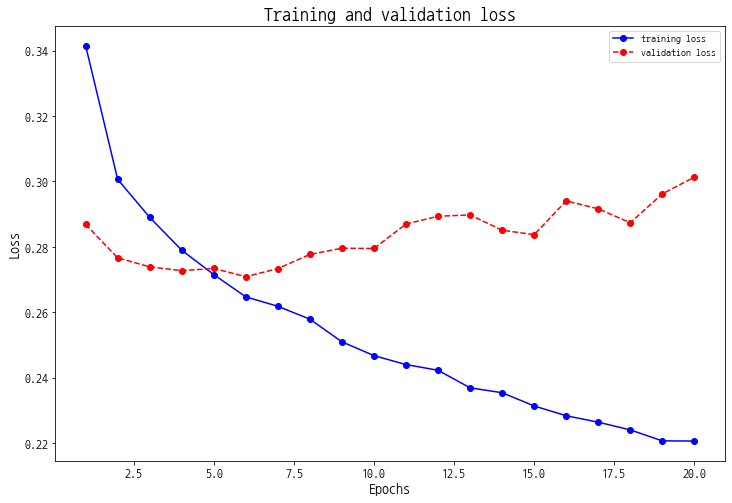

In [60]:
loss_and_acc_plot(history=history, class_mode=class_mode, num_plots=1)

검증 손실로 비교해 보면 이 설정은 규제가 있는 GRU 모델만큼 좋지는 않습니다. 하지만 훨씬 빠르기 때문에 데이터를 2배 더 많이 처리할 수 있습니다.